Using device: cuda


/home/vicente/Github/NIH-Chest-X-ray-Dataset/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['No Finding'] will be ignored
  warnings.warn(


MultiLabelBinarizer fitted on entire dataset.
Validation DataLoader is ready


/tmp/ipykernel_90011/1374821553.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded and set to evaluation mode


Generating Predictions: 100%|██████████| 707/707 [01:02<00:00, 11.26it/s]


Probability Statistics:
Min: 0.0000, Max: 0.9645, Mean: 0.0560, Std: 0.0894
Total Predictions Above Threshold (0.1): 55868
=== Overall Evaluation Metrics ===
Accuracy: 0.1196
Precision (Macro): 0.1937
Recall (Macro): 0.4722
F1-Score (Macro): 0.2564
Precision (Micro): 0.1988
Recall (Micro): 0.6662
F1-Score (Micro): 0.3063

Classification Report
                    precision    recall  f1-score   support

       Atelectasis       0.19      0.80      0.30      2364
      Cardiomegaly       0.24      0.45      0.31       548
          Effusion       0.27      0.85      0.41      2701
      Infiltration       0.19      0.93      0.32      4048
              Mass       0.21      0.39      0.28      1222
            Nodule       0.17      0.31      0.22      1270
         Pneumonia       0.06      0.03      0.04       275
      Pneumothorax       0.22      0.63      0.33      1165
     Consolidation       0.12      0.49      0.19       918
             Edema       0.12      0.55      0.19    

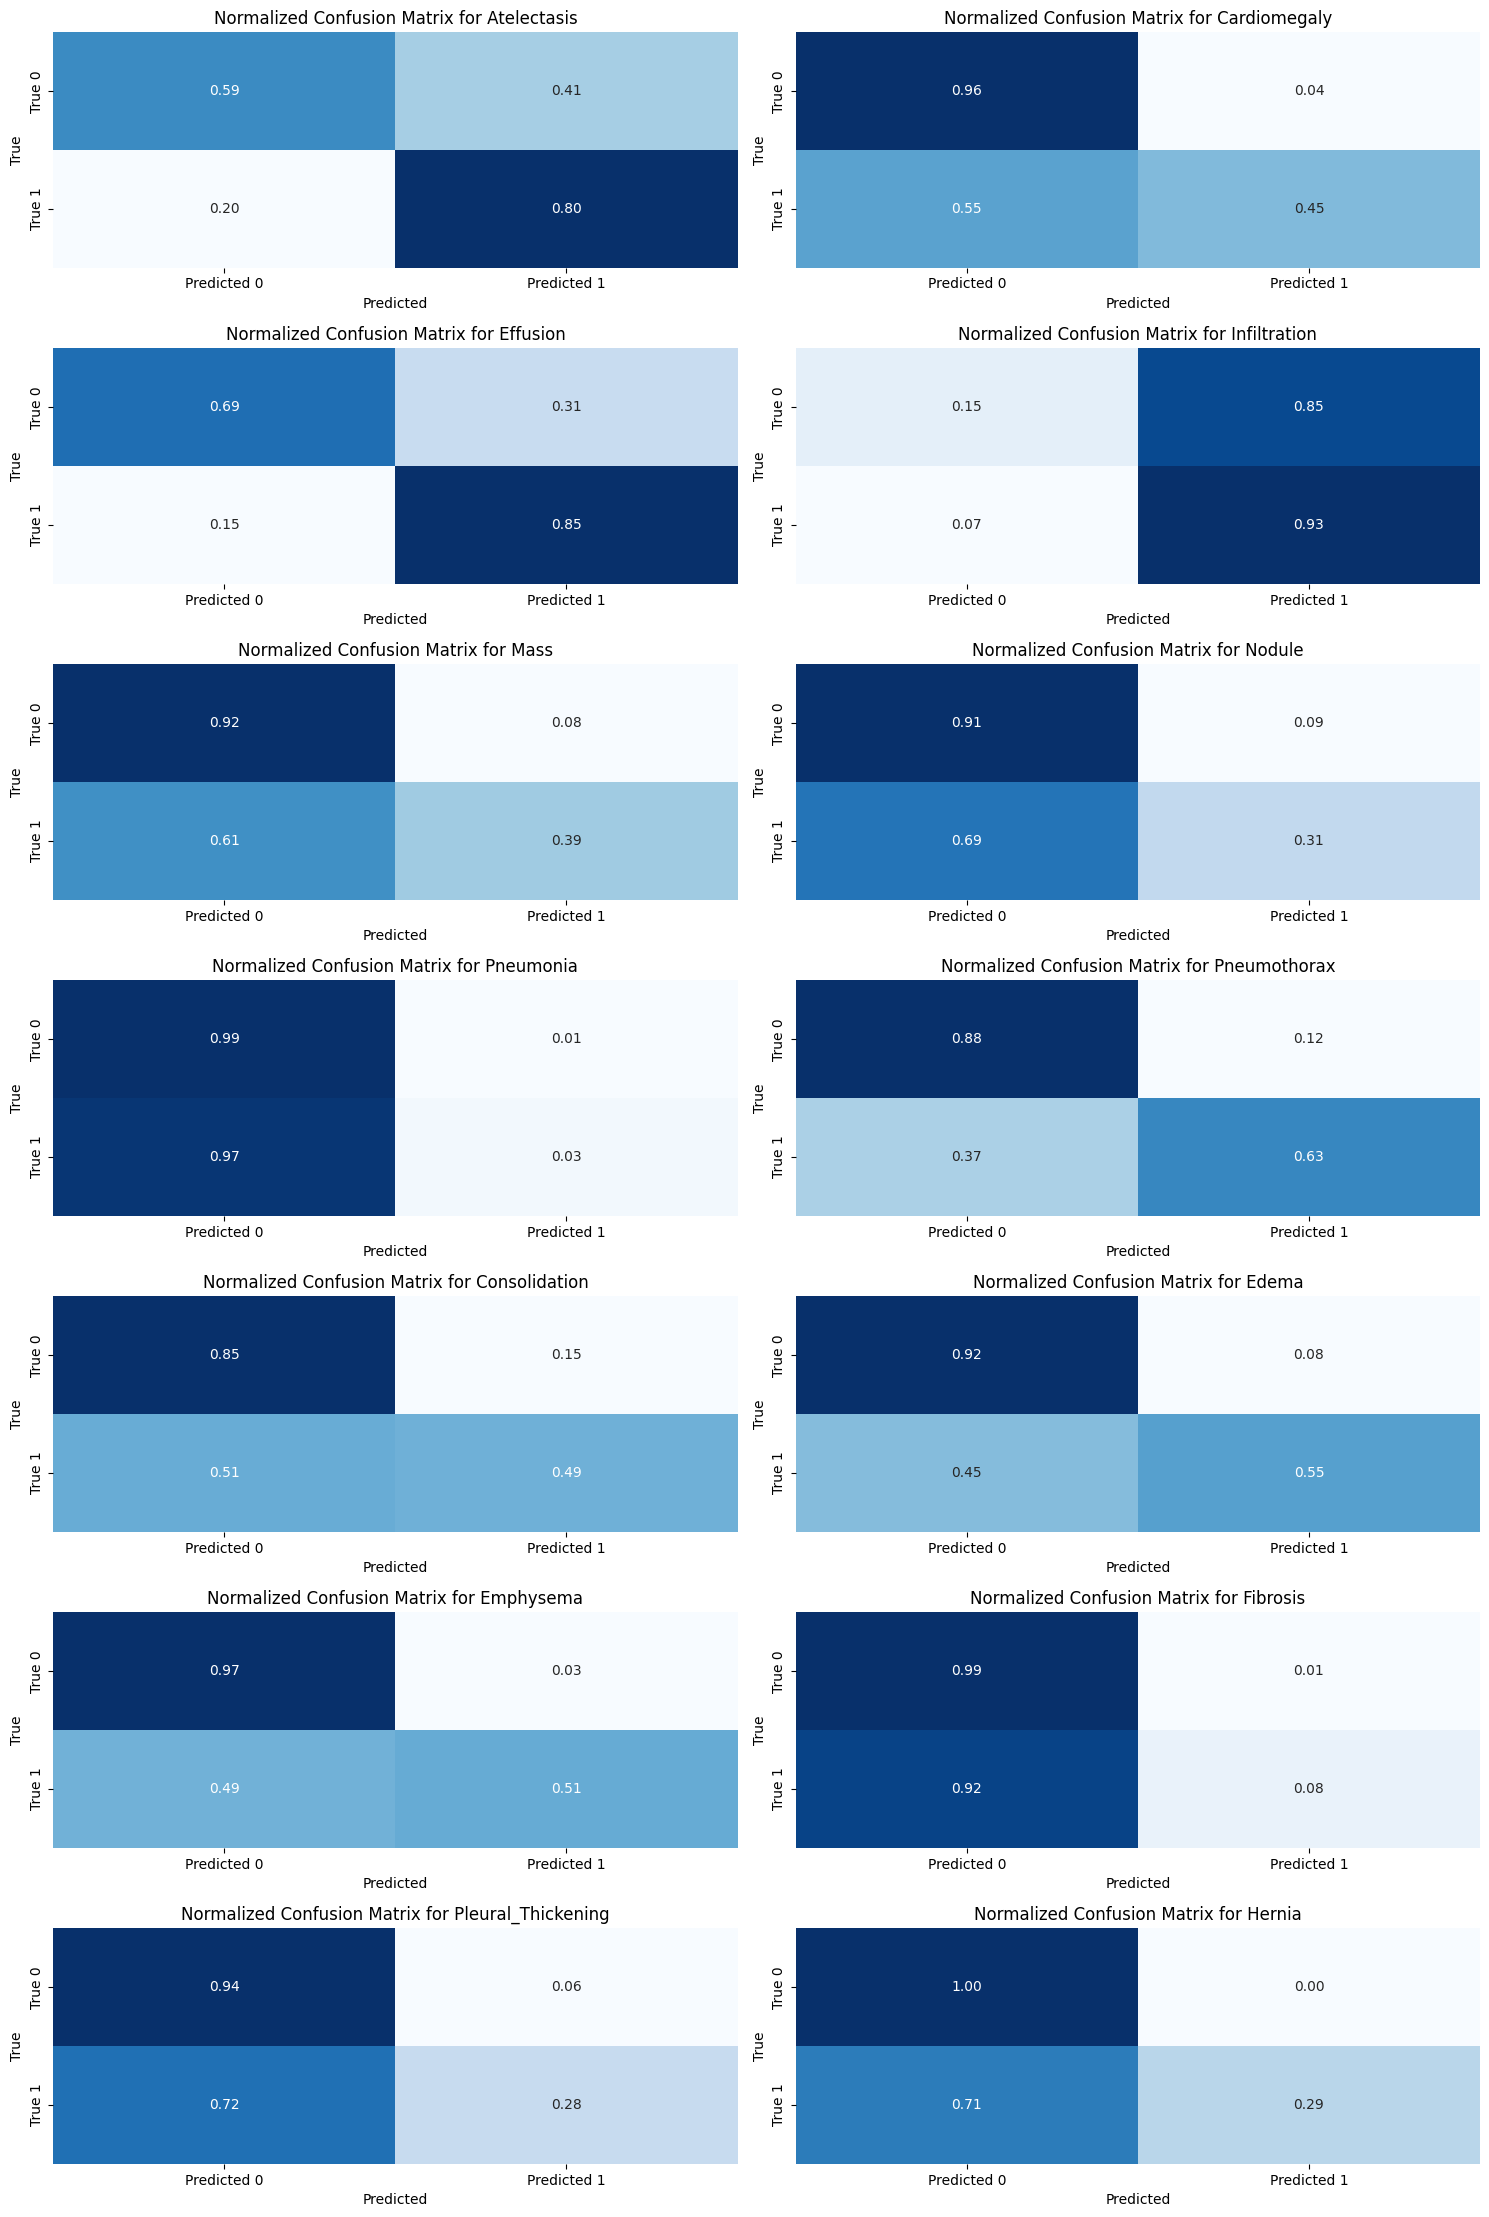

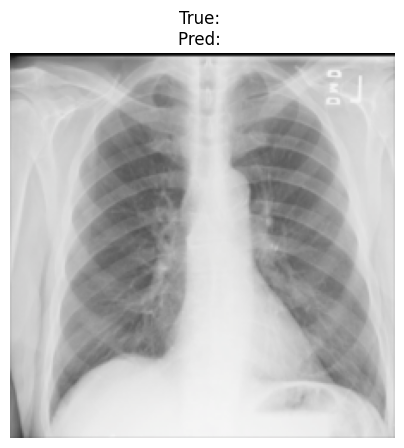

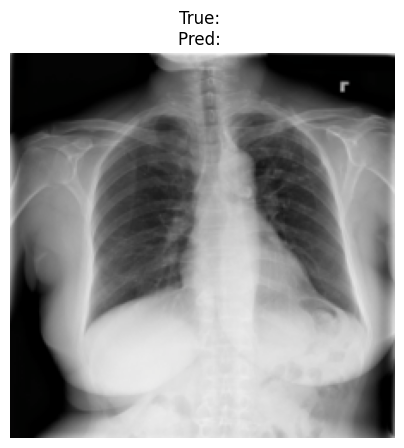

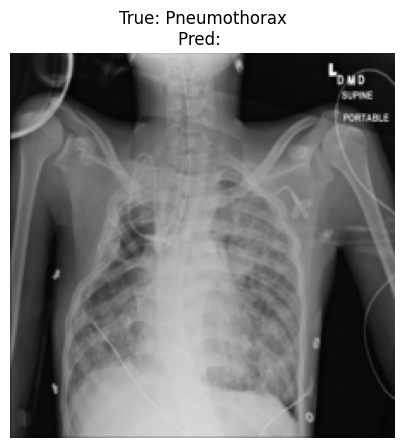

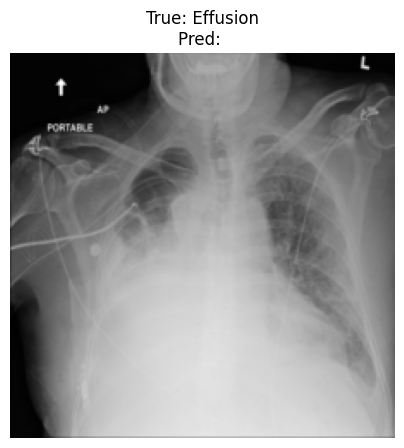

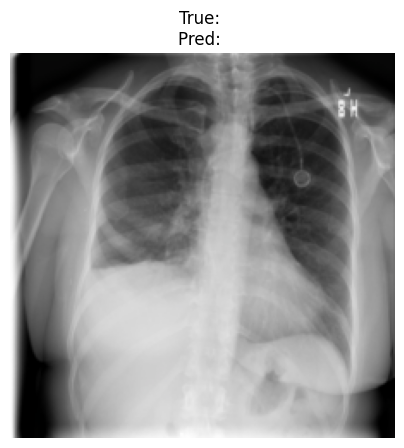

In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    multilabel_confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
from dataset import ChestXRayDataset
from CNN import create_model
%matplotlib inline

# Define classes
classes = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

NUM_CLASSES = 14
IMAGE_SIZE = 224  
BATCH_SIZE = 32

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize MultiLabelBinarizer with the same classes as training
mlb = MultiLabelBinarizer(classes=classes)

# Load and preprocess the data
DATA_CSV = "Data/Data_Entry_2017_v2020.csv" 
IMAGES_DIR = "Data/images/" 

images = pd.read_csv(DATA_CSV)

# Rename columns for consistency
images.columns = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position",
    "OriginalImageWidth", "OriginalImageHeight",
    "OriginalImagePixelSpacing_x", "OriginalImagePixelSpacing_y"
]

# Split the labels and encode them
images['Finding Labels'] = images['Finding Labels'].str.split('|')

# Fit the MultiLabelBinarizer on the entire dataset (consistent with training)
y = mlb.fit_transform(images['Finding Labels'])
print("MultiLabelBinarizer fitted on entire dataset.")

# Split the data into training and validation sets based on Patient ID
train_patients, val_patients = train_test_split(
    images['Patient ID'].unique(),
    test_size=0.2,
    random_state=1  
)

train_df = images[images['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = images[images['Patient ID'].isin(val_patients)].reset_index(drop=True)

# Encode labels for training and validation
train_y = mlb.transform(train_df['Finding Labels'])
val_y = mlb.transform(val_df['Finding Labels'])

# Define validation transforms (same as training)
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create validation dataset and loader
val_dataset = ChestXRayDataset(val_df, val_y, IMAGES_DIR, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)  

print("Validation DataLoader is ready")

# Load the trained model
model = create_model(num_classes=NUM_CLASSES)
model_path = "best_model_224.pth"  
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Model loaded and set to evaluation mode")

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Generate predictions
with torch.no_grad():
    for images_batch, labels_batch in tqdm(val_loader, desc="Generating Predictions"):
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        # Perform standard inference without autocast
        outputs = model(images_batch)
        
        preds = outputs.cpu().numpy()
        true_labels = labels_batch.cpu().numpy()
        
        all_preds.append(preds)
        all_labels.append(true_labels)

# Concatenate all predictions and labels
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Apply sigmoid to convert logits to probabilities
all_probs = 1 / (1 + np.exp(-all_preds))

# Inspect the distribution of probabilities
print("Probability Statistics:")
print(f"Min: {all_probs.min():.4f}, Max: {all_probs.max():.4f}, Mean: {all_probs.mean():.4f}, Std: {all_probs.std():.4f}")

# Define a lower threshold to see if any predictions are made
threshold = 0.1  # Adjust as needed
all_preds_binary = (all_probs > threshold).astype(int)
print(f"Total Predictions Above Threshold ({threshold}): {all_preds_binary.sum()}")

# If necessary, optimize thresholds per class
# Uncomment the following section to perform threshold optimization

# from sklearn.metrics import f1_score

# optimal_thresholds = []
# for i in range(NUM_CLASSES):
#     best_f1 = 0
#     best_thresh = 0.3
#     for thresh in np.linspace(0.1, 0.9, 9):
#         preds = (all_probs[:, i] > thresh).astype(int)
#         f1 = f1_score(all_labels[:, i], preds, zero_division=0)
#         if f1 > best_f1:
#             best_f1 = f1
#             best_thresh = thresh
#     optimal_thresholds.append(best_thresh)
#     print(f"Class {classes[i]} - Optimal Threshold: {best_thresh:.2f}, F1-Score: {best_f1:.4f}")

# # Apply class-specific thresholds
# all_preds_binary = np.zeros_like(all_probs, dtype=int)
# for i in range(NUM_CLASSES):
#     all_preds_binary[:, i] = (all_probs[:, i] > optimal_thresholds[i]).astype(int)

# print("Predictions generated with optimized thresholds.")

# Calculate overall evaluation metrics
accuracy = accuracy_score(all_labels, all_preds_binary)
precision_macro = precision_score(all_labels, all_preds_binary, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds_binary, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds_binary, average='macro', zero_division=0)

# Additionally, calculate micro-averaged metrics
precision_micro = precision_score(all_labels, all_preds_binary, average='micro', zero_division=0)
recall_micro = recall_score(all_labels, all_preds_binary, average='micro', zero_division=0)
f1_micro = f1_score(all_labels, all_preds_binary, average='micro', zero_division=0)

print("=== Overall Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")

# Classification Report
report = classification_report(all_labels, all_preds_binary, target_names=classes, zero_division=0)
print("\nClassification Report")
print(report)

# Multilabel Confusion Matrix
mcm = multilabel_confusion_matrix(all_labels, all_preds_binary)

# Plot normalized confusion matrices
plt.figure(figsize=(15, 25))
for i, class_name in enumerate(classes):
    cm = mcm[i].astype('float') / mcm[i].sum(axis=1)[:, np.newaxis] 
    plt.subplot(8, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Normalized Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()

# Visualize some sample predictions
import matplotlib.pyplot as plt
num_samples = 5
indices = random.sample(range(len(val_dataset)), num_samples)

# Define inverse normalization for visualization
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

for idx in indices:
    image, label = val_dataset[idx]
    
    inv_img = inv_normalize(image).permute(1,2,0).numpy().clip(0,1)
    
    plt.figure(figsize=(5,5))
    plt.imshow(inv_img)
    plt.axis('off')
    
    # Get true labels
    true_labels = [classes[j] for j, val in enumerate(label) if val == 1]
    
    # Get predictions
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(image_tensor).cpu().numpy().squeeze()
    pred_labels = [classes[j] for j, val in enumerate(pred > threshold) if val]
    
    plt.title(f"True: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}")
    plt.show()
